# Langraph Chatbot with Tools

In [ ]:
pip install langchain_community langgraph langsmith langchain langchain_groq

In [95]:
from typing import Annotated
from typing_extensions import TypedDict

## Working with external tools

In [97]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia tools

In [ ]:
pip install arxiv wikipedia

In [100]:
#Arxiv wrapper
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool =ArxivQueryRun(api_wrapper=arxiv_wrapper)

#wikipedia wrapper
wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [102]:
wiki_tool("who is actor Tom Cruise")

'Page: Tom Cruise filmography\nSummary: Tom Cruise is an American actor and producer who made his film debut with a minor role in the 1981 romantic drama Endless Love. 1985 stared in Legend.  Two years later, he made his breakthrough by starring in the romantic comedy Risky Business (1983), which garn'

In [104]:
arxiv_tool.invoke("Attentio is all you need")

'Published: 2018-07-02\nTitle: The Matrix Calculus You Need For Deep Learning\nAuthors: Terence Parr, Jeremy Howard\nSummary: This paper is an attempt to explain all the matrix calculus you need in order\nto understand the training of deep neural networks. We assume no math knowledge\nbeyond what you lear'

In [106]:
tools=[wiki_tool]

## Langraph Application

In [108]:
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list,add_messages]
    

In [110]:
from langgraph.graph import StateGraph,START,END

In [112]:
graph_builder = StateGraph(State)

In [114]:
from langchain_groq import ChatGroq

In [116]:
import os

# Define the API key or get it from environment variables
grok_api_key = os.getenv('grok_Api_key')

if grok_api_key is None:
    # Assign a value to the API key if it’s not found in the environment
    grok_api_key = "your_actual_api_key_here"  # Replace with your actual API key

# Set the environment variable
os.environ["grok_Api_key"] = grok_api_key
print("API key has been all set.")


API key has been all set.


In [118]:
llm=ChatGroq(groq_api_key=grok_api_key,model_name="Gemma2-9b-It")

In [120]:
llm_with_tools=llm.bind_tools(tools=tools)

In [122]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [126]:
from langgraph.prebuilt import ToolNode ,tools_condition

In [128]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [130]:
#complie graph
graph=graph_builder.compile()

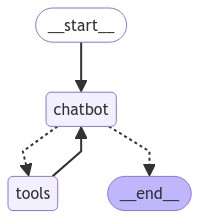

In [134]:
# display langraph and handling exceptions
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [146]:
user_input="Hi there!, My name is jhon"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is jhon
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_vm4t)
 Call ID: call_vm4t
  Args:
    query: jhon
================================= Tool Message =================================
Name: wikipedia

Page: Jhon Durán
Summary: Jhon Jader Durán Palacio (born 13 December 2003) is a Colombian professional footballer who plays as a forward for Premier League club Aston Villa and the Colombia national team.
================================== Ai Message ==================================

Hi Jhon, it's nice to meet you.  I see you are a professional footballer who plays for Aston Villa and the Colombia national team.


In [142]:
user_input = "what is RLHF."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is RLHF.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_x3zw)
 Call ID: call_x3zw
  Args:
    query: RLHF
================================= Tool Message =================================
Name: wikipedia

Page: Reinforcement learning from human feedback
Summary: In machine learning, reinforcement learning from human feedback (RLHF) is a technique to align an agent with human preferences. It involves training a reward model to represent preferences previously gathered from a sample of humans, which ca
================================== Ai Message ==================================

Reinforcement learning from human feedback (RLHF) is a technique to align an agent with human preferences. It involves training a reward model to represent preferences previously gathered from a sample of humans.
